In [87]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm, tqdm_notebook
import missingno as msno
%matplotlib inline
import matplotlib.pyplot as plt  
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [88]:
path  = r'../../data/rawData/'
train_sales  = pd.read_csv(path+'train/train_sales_data.csv')
train_search = pd.read_csv(path+'train/train_search_data.csv')
train_user   = pd.read_csv(path+'train/train_user_reply_data.csv')

evaluation_public = pd.read_csv(path+'test/evaluation_public.csv')
submit_example    = pd.read_csv(path+'submitExample/submit_example.csv')
data = pd.concat([train_sales, evaluation_public], ignore_index=True)

D:\develop\Anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


### train_sales/train_search/train_user,三者无缺失值

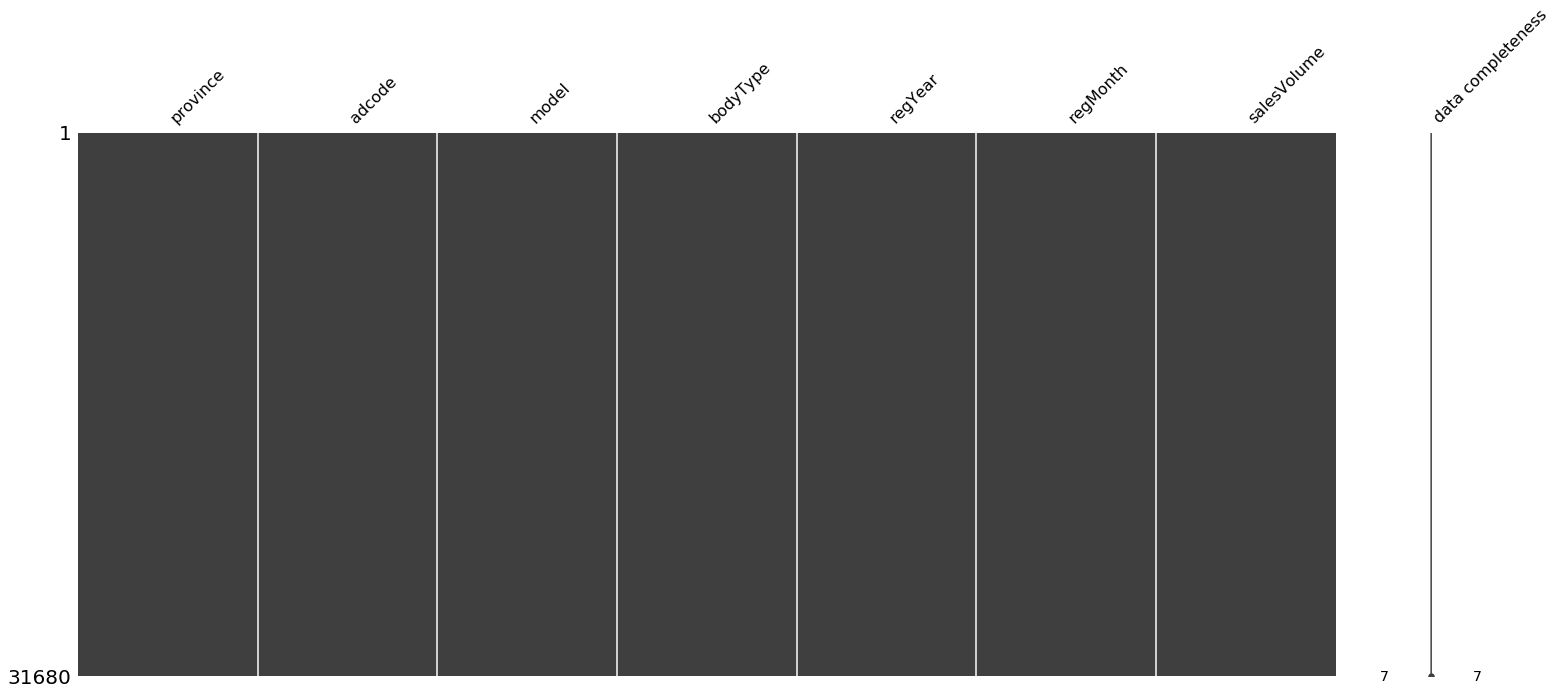

In [12]:
msno.matrix(train_sales,labels=True)

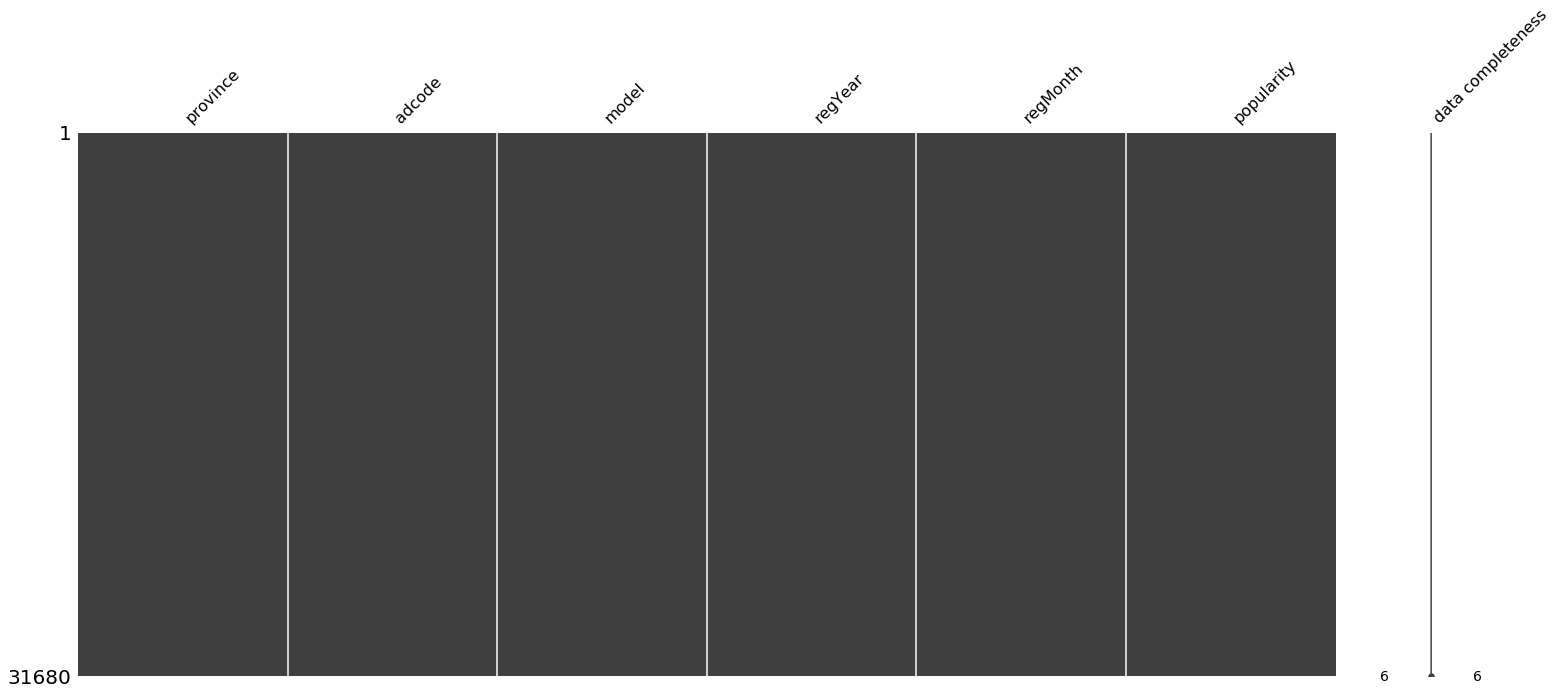

In [13]:
msno.matrix(train_search,labels=True)

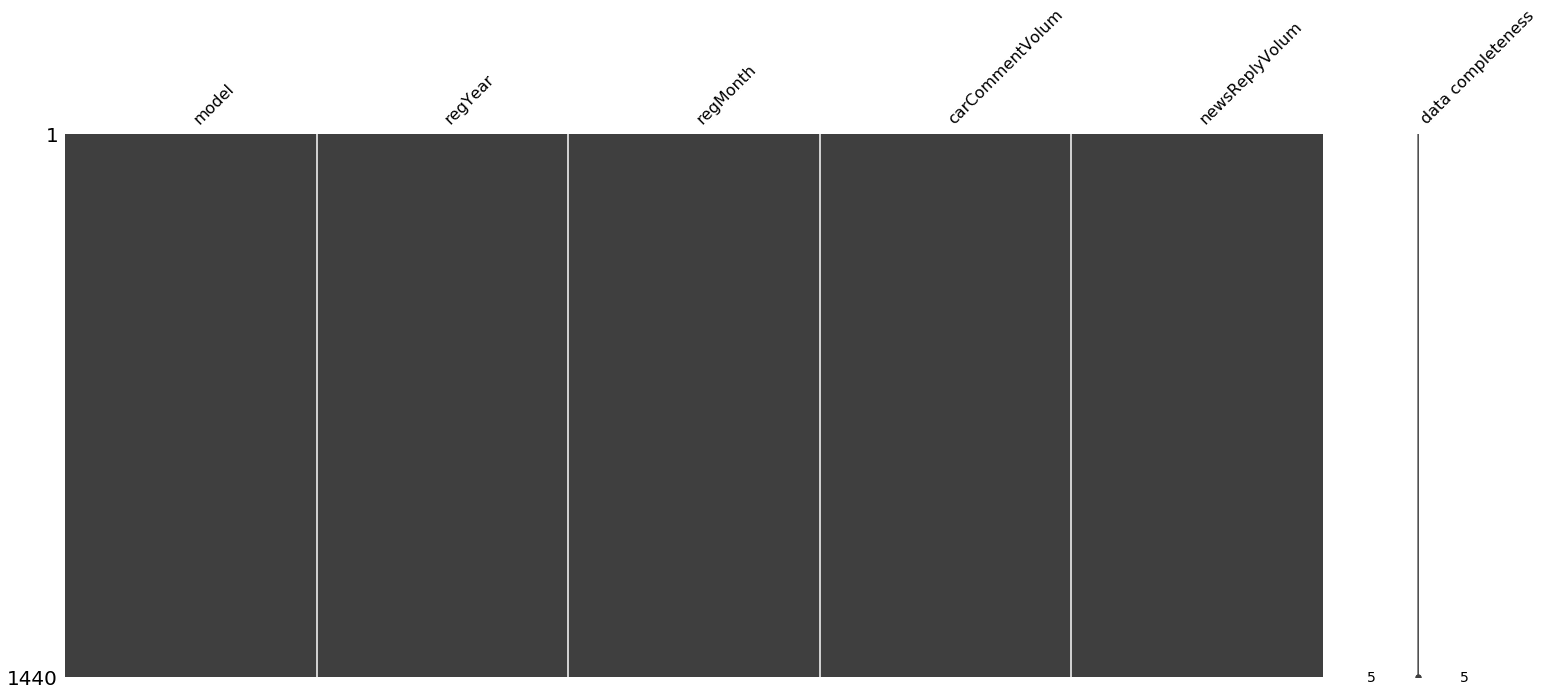

In [14]:
msno.matrix(train_user,labels=True)

In [89]:
data = data.merge(train_search, 'left', on=['province', 'adcode', 'model', 'regYear', 'regMonth'])
data = data.merge(train_user, 'left', on=['model', 'regYear', 'regMonth'])
data['label'] = data['salesVolume']
data['id'] = data['id'].fillna(0).astype(int)

In [90]:
data['bodyType'] = data['model'].map(train_sales.drop_duplicates('model').set_index('model')['bodyType'])

In [91]:
pro_dict=dict(zip(data['province'].unique(), range(data['province'].nunique())))
pro_dict_check=dict(zip(range(data['province'].nunique()), data['province'].unique()))
model_dict=dict(zip(data['model'].unique(), range(data['model'].nunique())))
model_dict_check=dict(zip(range(data['model'].nunique()), data['model'].unique()))
bodyType_dict=dict(zip(data['bodyType'].unique(), range(data['bodyType'].nunique())))
bodyType_dict_check=dict(zip(range(data['bodyType'].nunique()), data['bodyType'].unique()))



data['province'] = data['province'].map(pro_dict)
data['model'] = data['model'].map(model_dict)
data['bodyType'] = data['bodyType'].map(bodyType_dict)
data['mt'] = (data['regYear'] - 2016) * 12 + data['regMonth'] #monthAmount

D:\develop\Anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  This is separate from the ipykernel package so we can avoid doing imports until
D:\develop\Anaconda3\envs\python37\lib\site-packages\matplotlib\pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


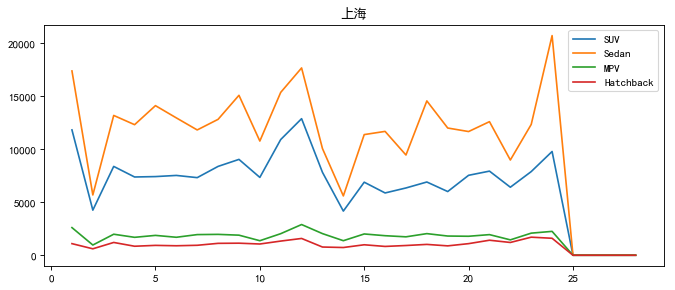

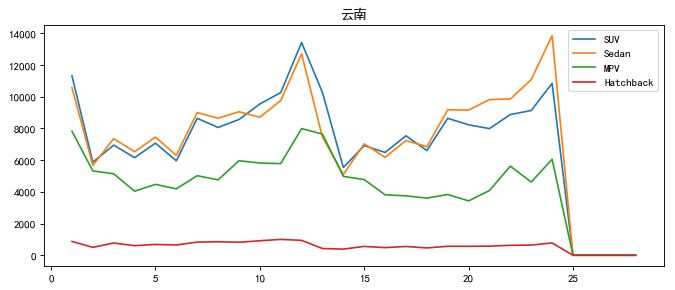

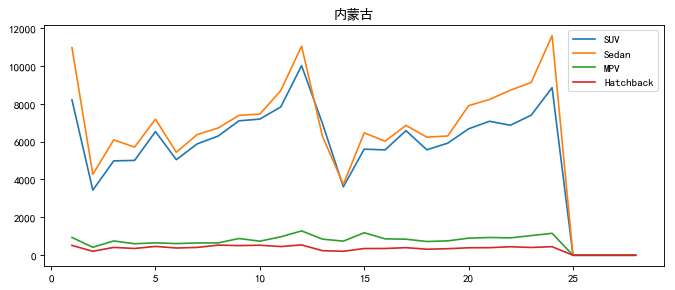

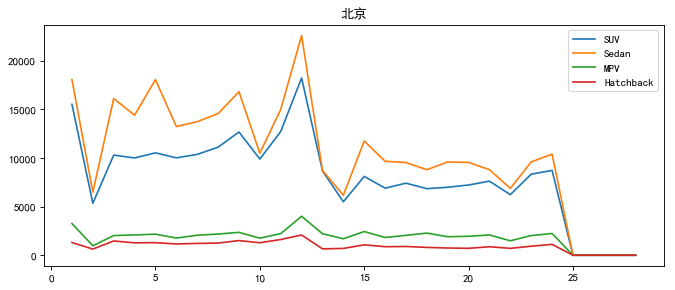

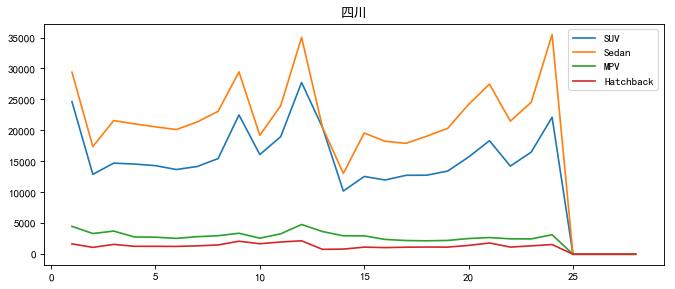

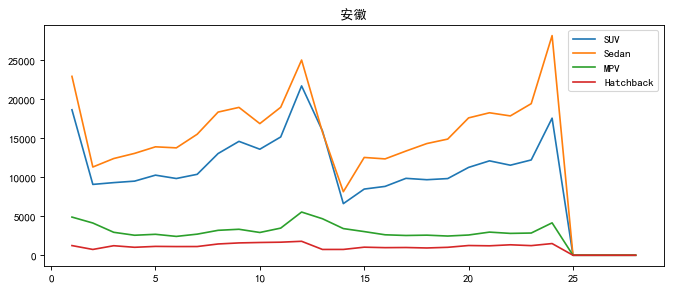

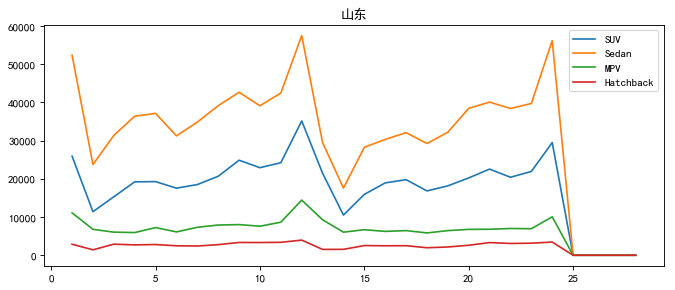

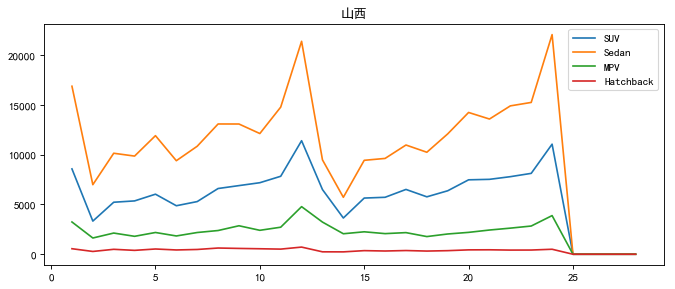

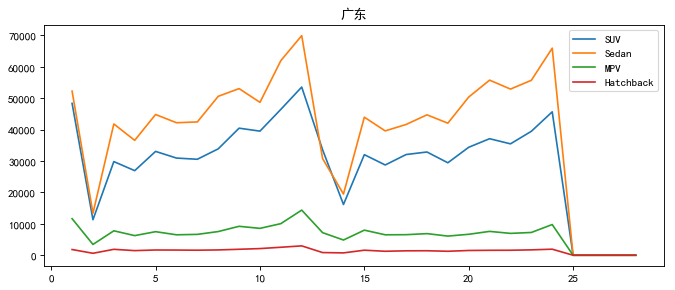

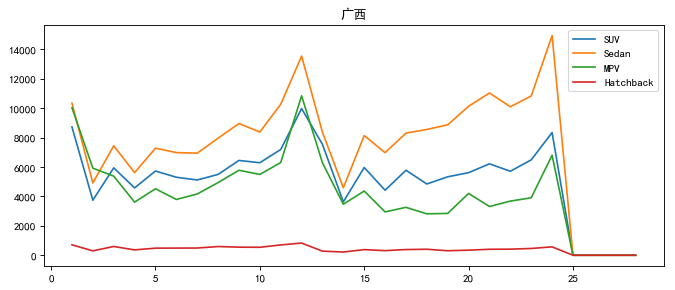

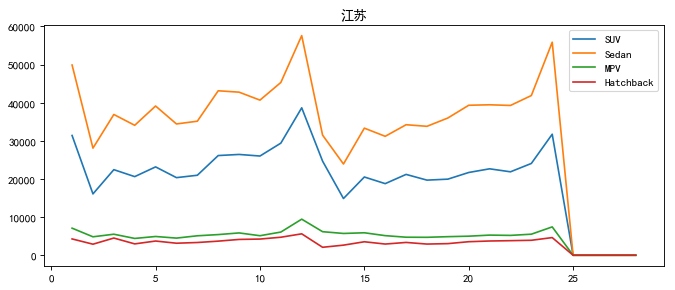

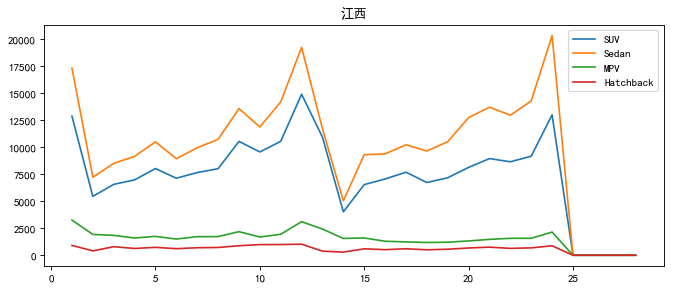

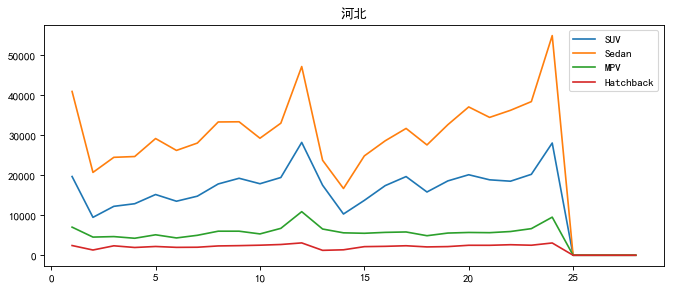

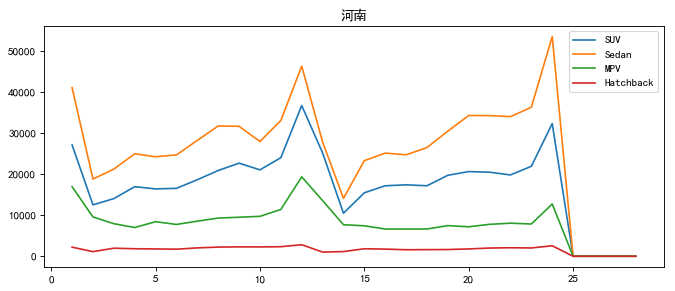

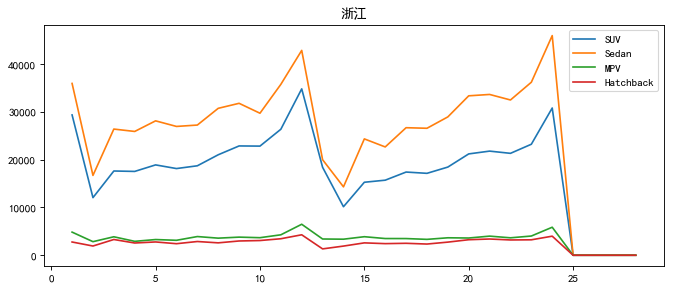

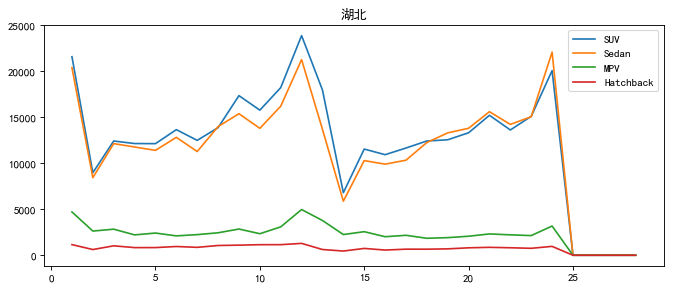

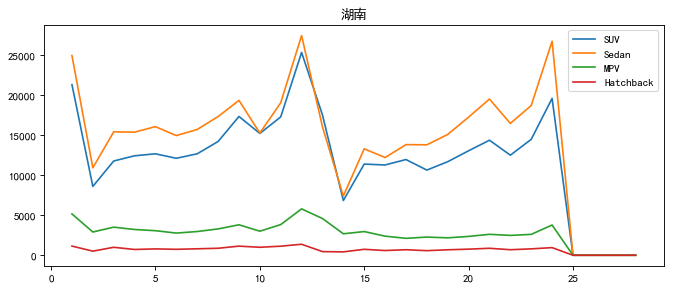

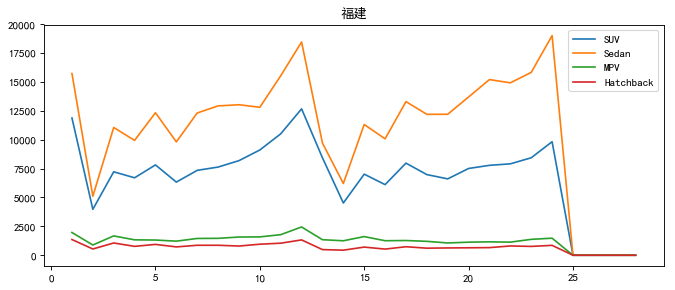

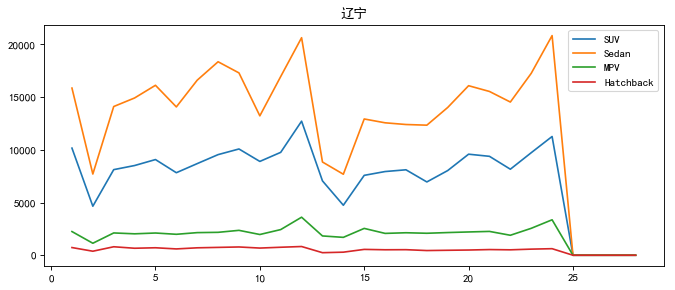

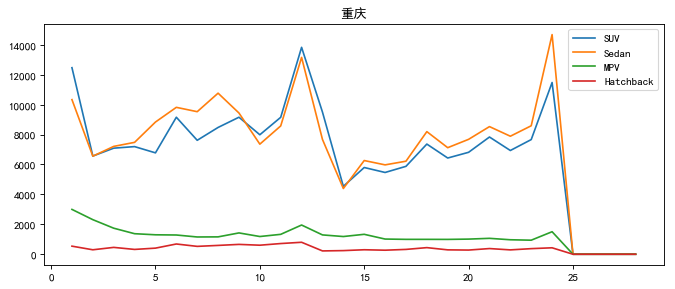

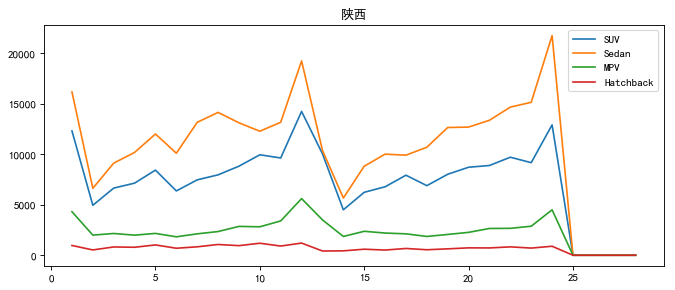

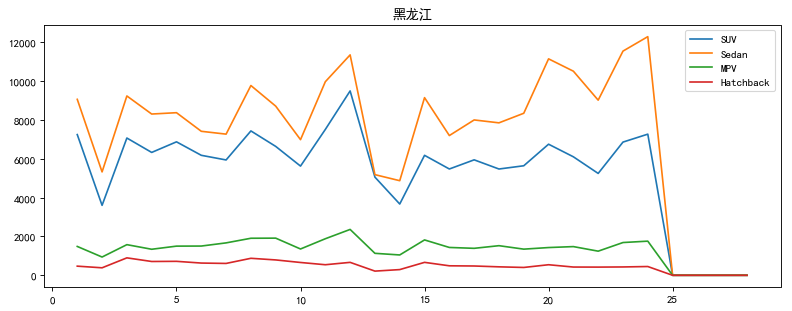

In [100]:
for i in pro_dict_check.keys():
    plt.figure(i,figsize=(10 ,4),dpi=80)
    single_pro = data.loc[data['province']==i,('mt','bodyType','salesVolume')].groupby(('mt','bodyType')).sum(axis=0).reset_index()
    plt.title(pro_dict_check.get(i))
    for j in bodyType_dict_check.keys():
        pro_body = single_pro[single_pro['bodyType']==j]
        plt.plot(pro_body['mt'],pro_body['salesVolume'],label=bodyType_dict_check.get(j))
        plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
分析每个省份中不同车型销量时序，发现：
1.年末年初为旺季，2,3月份为淡季
2.SUV,Sedan销量最多，拟合曲线接近
3.Hatchback销量惨淡、平缓，市场热度不高。考虑到此类车型为2厢，不符合国人审美，开出去没有牌面。
4.MPV销量略高于Hatchback,在广西、云南、河南等地，消费需求颇大，考虑到此类车型适合各类用户使用的多功能车，比面包车有牌面一些，也更加安全。公司可用于中短途商务旅行，职工交通车。MPV更适合家庭使用，假日里全家大小亲朋好友一起到郊外旅行，一辆MPV就可以轻松应付
5.建议须结合当地地理风景角度考虑